# Draft file

In [1]:
import json
from pathlib import Path

In [2]:
data_dir = Path("data", "geojson")
out_dir = Path("clean")


In [3]:
# Open and parse the geojson file
file_name = "Output0.geojson"

with open(data_dir / file_name) as f:
    data = json.load(f)


In [4]:
data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-63756.01578319579, -10414.190415866586],
      [-63837.95048326551, -13191.440814358793],
      [-58978.97625346371, -13191.440814358793],
      [-58978.97625346371, -33765.00256387098],
      [-43050.62825285748, -33765.00256387098],
      [-43050.62825285748, -50988.39935616695],
      [-42099.22234913107, -50988.39935616695],
      [-42099.22234913107, -65078.15990299577],
      [-39385.13083050569, -65078.15990299577],
      [-39385.13083050569, -36283.99786436476],
      [-16621.451263132796, -36283.99786436476],
      [-16621.451263132796, -41483.828077261365],
      [-14009.968091753835, -41483.828077261365],
      [-14009.968091753835, -29956.72772752217],
      [-4859.892984029837, -29956.72772752217],
      [-4859.892984029837, -28075.077159920533],
      [-11175.87418012711, -28075.077159920533],
      [-11175.87418012711, -22552.97553125862],
      [-165

In [5]:
# Count the kind of features
feature_count = {}
for feature in data["features"]:
    feature_type = feature["geometry"]["type"]
    if feature_type not in feature_count:
        feature_count[feature_type] = 0
    feature_count[feature_type] += 1
print(feature_count)

{'Polygon': 4, 'MultiLineString': 1}


In [6]:
# Open all files in folder data_dir, then parse them and count the kind of features

for file in data_dir.iterdir():
    with open(file) as f:
        data = json.load(f)
    feature_count = {}
    for feature in data["features"]:
        feature_type = feature["geometry"]["type"]
        if feature_type not in feature_count:
            feature_count[feature_type] = 0
        feature_count[feature_type] += 1
    print(file, feature_count)

data/geojson/Output3.geojson {'MultiLineString': 1}
data/geojson/Output2.geojson {'Polygon': 18, 'MultiLineString': 1}
data/geojson/Output0.geojson {'Polygon': 4, 'MultiLineString': 1}
data/geojson/Output1.geojson {'Polygon': 251, 'MultiLineString': 1}
data/geojson/Output4.geojson {'Polygon': 6, 'MultiLineString': 1}
data/geojson/Output5.geojson {'Polygon': 94, 'MultiLineString': 1}
data/geojson/Output9_clinique.geojson {'Polygon': 152, 'MultiLineString': 1}
data/geojson/Output10_circ.geojson {'Polygon': 70, 'MultiLineString': 1}
data/geojson/Output6.geojson {'Polygon': 685, 'MultiLineString': 1}


We only have two kinds of features: Polygon and MultiLineString that share 
the same geometry["coordinates] : list[list[float]]
They have no other identifier but their index in the features list in the file.

We only need to parse lines.

We will parse first time, then try to infer the scale of the plan (m or mm), then normalize
the bottom left corner at point (0,0)

In [7]:
def read_box_from_file(filepath):
    with open(filepath) as f:
        data = json.load(f)
    min_x = min_y = float("inf")
    max_x = max_y = float("-inf")
    for feature in data["features"]:
        multi_line = feature["geometry"]["coordinates"]
        for line in multi_line:
            for x, y in line:
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
    print(f"{filepath}: {min_x:.3f}, {min_y:.3f}, {max_x:.3f}, {max_y:.3f}")

In [9]:
def find_float_pairs(data):
    float_pairs = []

    def search(data):
        if isinstance(data, list):
            if len(data) == 2 and all(isinstance(item, float) for item in data):
                float_pairs.append(data)
            for item in data:
                search(item)
        elif isinstance(data, dict):
            for key, value in data.items():
                search(value)

    search(data)
    return float_pairs


# Example usage
filepath = data_dir / "Output0.geojson"
with open(filepath) as f:
    data = json.load(f)

float_pairs = find_float_pairs(data)
print(float_pairs)

[[-63756.01578319579, -10414.190415866586], [-63837.95048326551, -13191.440814358793], [-58978.97625346371, -13191.440814358793], [-58978.97625346371, -33765.00256387098], [-43050.62825285748, -33765.00256387098], [-43050.62825285748, -50988.39935616695], [-42099.22234913107, -50988.39935616695], [-42099.22234913107, -65078.15990299577], [-39385.13083050569, -65078.15990299577], [-39385.13083050569, -36283.99786436476], [-16621.451263132796, -36283.99786436476], [-16621.451263132796, -41483.828077261365], [-14009.968091753835, -41483.828077261365], [-14009.968091753835, -29956.72772752217], [-4859.892984029837, -29956.72772752217], [-4859.892984029837, -28075.077159920533], [-11175.87418012711, -28075.077159920533], [-11175.87418012711, -22552.97553125862], [-16507.05217203818, -22552.97553125862], [-16507.05217203818, -33579.85317556918], [-22020.490038174787, -33579.85317556918], [-22020.490038174787, -28256.90568786682], [-33383.94304979668, -28256.90568786682], [-33383.94304979668,

In [10]:
%%timeit
filepath = data_dir / "Output0.geojson"
with open(filepath) as f:
    data = json.load(f)

float_pairs = find_float_pairs(data)

20.9 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Operations

In [12]:
from importlib import reload
import parse_geojson

reload(parse_geojson)


filepath = data_dir / "Output0.geojson"
segments_0 = parse_geojson.parse_segments_geojson(filepath)
print(len(segments_0))

data/geojson/Output0.geojson: -96597.654, -82411.475, 214.174, -10203.309
data/geojson/Output0.geojson: 5828 segments
5828


In [13]:
# plot my segment list

import matplotlib.pyplot as plt


def plot_segments(segments, ax):
    for segment in segments:
        ax.plot(*segment.plotable(), ".-", color="black")
    # plt.gca().set_aspect('equal', adjustable='box')
    ax.set_aspect("equal", adjustable="box")

In [14]:
x, y, f = parse_geojson.compute_factor_correction(filepath)
print(type(x), type(y), type(f))

data/geojson/Output0.geojson: -96597.654, -82411.475, 214.174, -10203.309
<class 'float'> <class 'float'> <class 'float'>


In [16]:
segments_0_c = parse_geojson.parse_segments_geojson(filepath)
segments_0_c[:10]

data/geojson/Output0.geojson: -96597.654, -82411.475, 214.174, -10203.309
data/geojson/Output0.geojson: 5828 segments


[Segment((32.84, 72.00), (32.76, 69.22)),
 Segment((32.76, 69.22), (37.62, 69.22)),
 Segment((37.62, 69.22), (37.62, 48.65)),
 Segment((37.62, 48.65), (53.55, 48.65)),
 Segment((53.55, 48.65), (53.55, 31.42)),
 Segment((53.55, 31.42), (54.50, 31.42)),
 Segment((54.50, 31.42), (54.50, 17.33)),
 Segment((54.50, 17.33), (57.21, 17.33)),
 Segment((57.21, 17.33), (57.21, 46.13)),
 Segment((57.21, 46.13), (79.98, 46.13))]

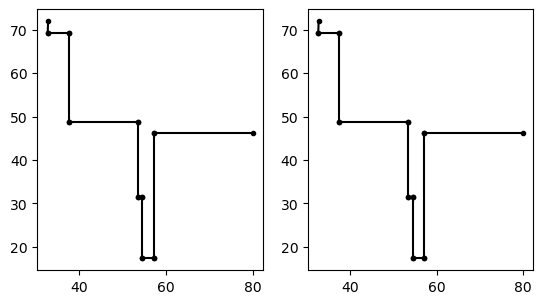

In [17]:
fig, axs = plt.subplots(1, 2)
plot_segments(segments_0[:10], axs[0])
plot_segments(segments_0_c[:10], axs[1])
plt.show()

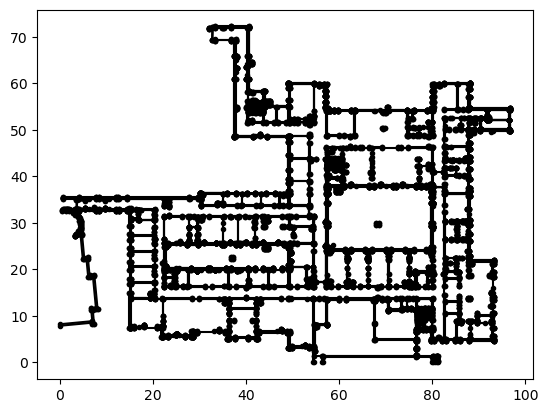

In [18]:
plot_segments(segments_0, plt.gca())

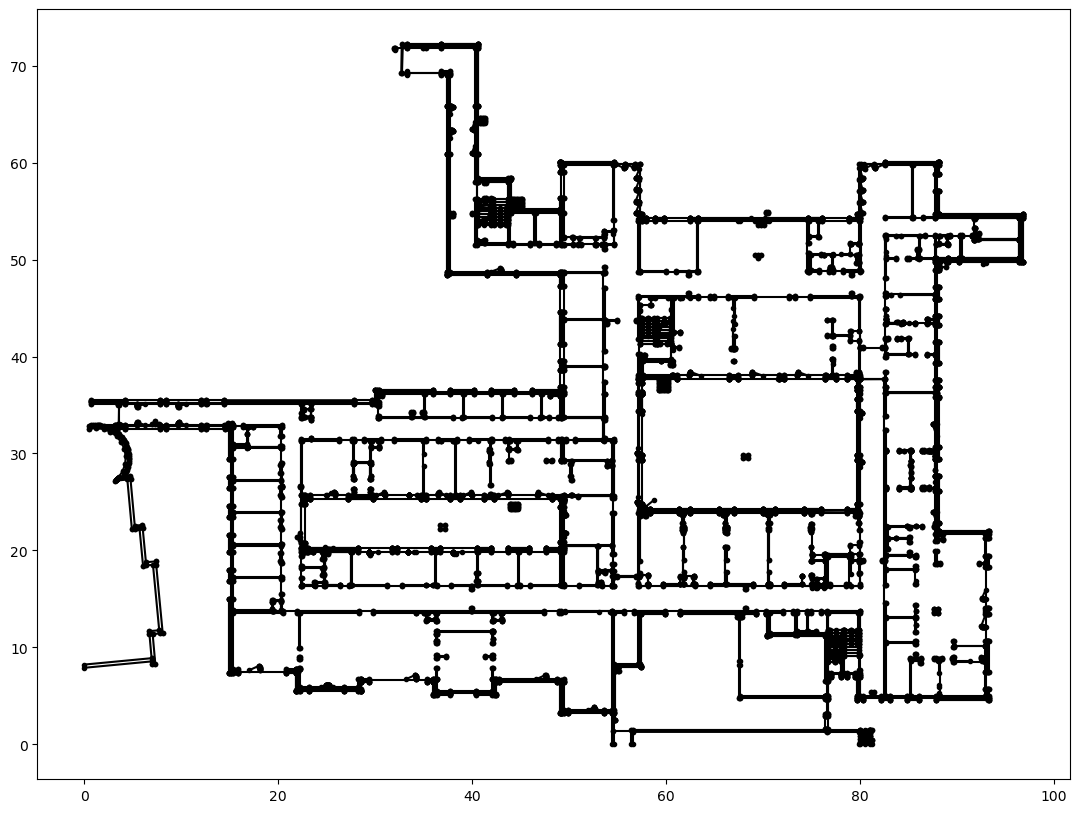

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_segments(segments_0, ax)

In [6]:
# Check the files
for file in data_dir.iterdir():
    segments = parse_geojson.parse_segments_geojson(file)
    fig, ax = plt.subplots(figsize=(30, 30))
    plot_segments(segments, ax)
    ax.set_title(file.name)

NameError: name 'data_dir' is not defined

### Merge with Shapely

In [23]:
reload(parse_geojson)
# Check the files
for file in data_dir.iterdir():
    segments = parse_geojson.parse_segments_geojson(file)
    fig, ax = plt.subplots(figsize=(30, 30))
    plot_segments(segments, ax)
    ax.set_title(file.name)
    break

data/geojson/Output3.geojson: 9.355, 8.811, 97.959, 49.014


TypeError: unsupported operand type(s) for *: 'Point' and 'float'

In [28]:
# Load a file
import shapely

with open(filepath) as f:
    data = json.load(f)
geometry = data["features"]
for feature in geometry:
    parse_shapely = shapely.from_geojson(feature["geometry"])
    print(parse_shapely)


TypeError: Expected bytes or string, got dict

In [46]:
import json
from shapely.geometry import shape, GeometryCollection

with open(filepath) as f:
    features = json.load(f)["features"]

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates
# GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
geocol = GeometryCollection(
    [shape(feature["geometry"]) for feature in features]
)
feat_list = [shape(feature["geometry"]) for feature in features]

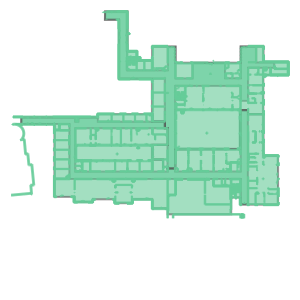

In [32]:
geocol

In [39]:
for feature in geocol.geoms:
    print(feature)

POLYGON ((-63756.01578319579 -10414.190415866586, -63837.95048326551 -13191.440814358793, -58978.97625346371 -13191.440814358793, -58978.97625346371 -33765.00256387098, -43050.62825285748 -33765.00256387098, -43050.62825285748 -50988.39935616695, -42099.22234913107 -50988.39935616695, -42099.22234913107 -65078.15990299577, -39385.13083050569 -65078.15990299577, -39385.13083050569 -36283.99786436476, -16621.451263132796 -36283.99786436476, -16621.451263132796 -41483.828077261365, -14009.968091753835 -41483.828077261365, -14009.968091753835 -29956.72772752217, -4859.892984029837 -29956.72772752217, -4859.892984029837 -28075.077159920533, -11175.87418012711 -28075.077159920533, -11175.87418012711 -22552.97553125862, -16507.05217203818 -22552.97553125862, -16507.05217203818 -33579.85317556918, -22020.490038174787 -33579.85317556918, -22020.490038174787 -28256.90568786682, -33383.94304979668 -28256.90568786682, -33383.94304979668 -33658.04635977588, -39315.29706472269 -33658.04635977588, -3

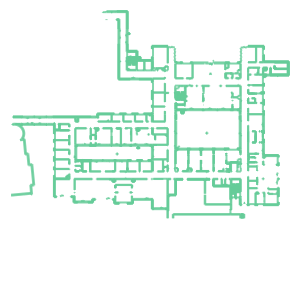

In [36]:
geocol.geoms[-1]

In [38]:
len(geocol.geoms)

5

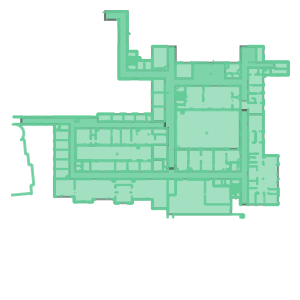

In [40]:
geocol.simplify(tolerance=1, preserve_topology=False)

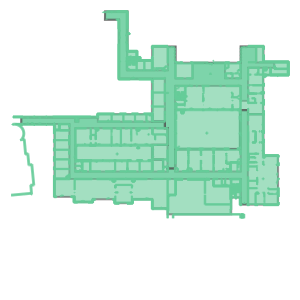

In [41]:
geocol.simplify(tolerance=1, preserve_topology=True)

In [45]:
for feature in geocol.geoms:
    feature.coords
    break

NotImplementedError: Component rings have coordinate sequences, but the polygon does not

In [47]:
feat_list

[<POLYGON ((-63756.016 -10414.19, -63837.95 -13191.441, -58978.976 -13191.441...>,
 <POLYGON ((-63859.886 -10223.67, -63914.901 -13203.345, -59026.961 -13203.34...>,
 <POLYGON ((-93016.43 -47223.347, -93058.106 -49543.525, -76287.409 -49543.52...>,
 <POLYGON ((-16804.758 -58311.012, -39393.304 -58440.665, -39393.304 -65077.0...>,
 <MULTILINESTRING ((-38750.208 -57947.204, -37828.354 -57199.715), (-3556.632...>]

In [54]:
geocol.geoms[0].bounds
# (minx, miny, maxx, maxy)

(-63837.95048326551,
 -65078.15990299577,
 -4859.892984029837,
 -10414.190415866586)

In [56]:
geocol.bounds

(-96597.65433833403,
 -82411.47514528442,
 214.17449418431556,
 -10203.308514696178)

In [57]:
shapely.get_coordinates(geocol)

array([[-63756.0157832 , -10414.19041587],
       [-63837.95048327, -13191.44081436],
       [-58978.97625346, -13191.44081436],
       ...,
       [-66242.64669146, -48634.91946225],
       [-66242.6465967 , -48734.91946225],
       [-58613.09443655, -48734.91223264]], shape=(10962, 2))

In [64]:
def offset_reduce(geom, shift_x, shift_y, factor):
    geom[:, 0] = (geom[:, 0] - shift_x) * factor
    geom[:, 1] = (geom[:, 1] - shift_y) * factor
    return geom


def transform_offset_reduce(geocol):
    min_x, min_y, max_x, max_y = geocol.bounds
    MAX_BAT_SIZE_IN_M = 1_000  # Buildings are never bigger than 1km
    # Modify the factor to work in meters
    if max_x - min_x > MAX_BAT_SIZE_IN_M or max_y - min_y > MAX_BAT_SIZE_IN_M:
        factor = 1 / 1_000
    else:
        factor = 1

    return shapely.transform(
        geocol, lambda x: offset_reduce(x, min_x, min_y, factor)
    )

In [67]:
transform_geocol = transform_offset_reduce(geocol)

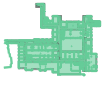

In [68]:
transform_geocol


In [69]:
transform_geocol.bounds

(0.0, 0.0, 96.81182883251836, 72.20816663058824)

In [71]:
shapely.get_coordinates(transform_geocol)

array([[32.84163856, 71.99728473],
       [32.75970386, 69.22003433],
       [37.61867808, 69.22003433],
       ...,
       [30.35500765, 33.77655568],
       [30.35500774, 33.67655568],
       [37.9845599 , 33.67656291]], shape=(10962, 2))

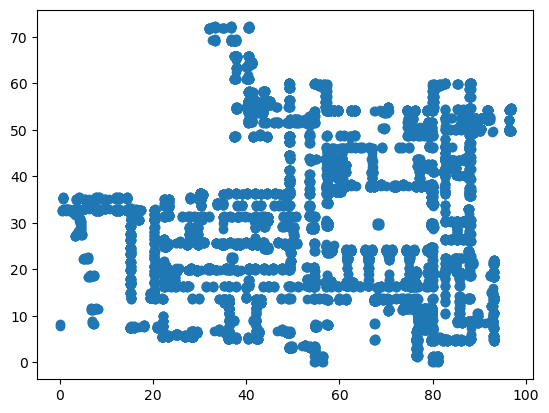

In [72]:
X = shapely.get_coordinates(transform_geocol)[:, 0]
Y = shapely.get_coordinates(transform_geocol)[:, 1]
plt.scatter(X, Y)

In [76]:
type(transform_geocol)

shapely.geometry.collection.GeometryCollection

In [86]:
reload(parse_geojson)
# control of the invariance
for filepath in data_dir.iterdir():
    print(filepath)
    geom_col = parse_geojson._load_GeometryCollection_from_geojson(filepath)
    print("\t", geom_col.bounds)
    geom_red, transo_params = parse_geojson._offset_reduce_GeometryCollection(
        geom_col
    )
    print("\t", geom_red.bounds)
    inv_geom = parse_geojson.inverse_transform(geom_red, *transo_params)
    print("\t", inv_geom.bounds)


data/geojson/Output3.geojson
	 (9.35511591685751, 8.81088134718489, 97.9588887771491, 49.0142219098659)
	 (0.0, 0.0, 88.60377286029158, 40.203340562681014)
	 (9.35511591685751, 8.81088134718489, 97.9588887771491, 49.0142219098659)
data/geojson/Output2.geojson
	 (-378955.8177593881, 339833.89240163006, -349483.04117433657, 385197.73762852815)
	 (0.0, 0.0, 29.47277658505156, 45.36384522689809)
	 (-378955817.75938815, 339833892.40163004, -378926344.9828031, 339879256.2468569)
data/geojson/Output0.geojson
	 (-96597.65433833403, -82411.47514528442, 214.17449418431556, -10203.308514696178)
	 (0.0, 0.0, 96.81182883251836, 72.20816663058824)
	 (-96597654.33833404, -82411475.14528441, -96500842.50950152, -82339266.97865383)
data/geojson/Output1.geojson
	 (558.2739391964515, 440.1539349014174, 28018.27393919645, 141300.1539349242)
	 (0.0, 0.0, 27.46, 140.86000000002278)
	 (558273.9391964515, 440153.9349014174, 585733.9391964515, 581013.9349014402)
data/geojson/Output4.geojson
	 (-150.52902158125

In [91]:
for geom in geom_red.geoms:
    print(type(geom))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

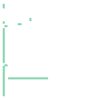

In [97]:
geom_red.geoms[-1].geoms[0:10]

In [108]:
reload(parse_geojson)
parse_geojson._extract_segments_from_MultiLineString(geom_red.geoms[-1])

TypeError: 'MultiLineString' object is not iterable

In [104]:
len(geom_red.geoms[-1].geoms)

1554

In [114]:
geom_red.geoms[-1].geoms[0].xy

(array('d', [39.42289509029744, 39.45289684332137]),
 array('d', [45.24064950865989, 43.39064953708815]))

In [116]:
geom_red.geoms[-1].geoms[0].coords[:]

[(39.42289509029744, 45.24064950865989),
 (39.45289684332137, 43.39064953708815)]

In [142]:
reload(parse_geojson)
segments_6 = parse_geojson.extract_segments(geom_red)

Start of extraction -----------------------
5044 segments extracted
4909 unique segments
End of extraction -----------------------


In [123]:
for geom in geom_red.geoms:
    for feature in geom.:
        print(feature)

TypeError: 'Polygon' object is not iterable

In [144]:
# Display the SVG
GeometryCollection(segments_6).svg(scale_factor=1, color="#66cc99”")

'<g><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="49.553484987309915,36.31100139264376 49.55344634750139,36.37899942191373" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="24.14947730956327,56.797062276159274 24.149477176902,56.93706227615921" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="57.450519873599504,11.925093831252962 57.25052037397977,11.925093641736865" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="54.79853142485951,5.411996536829029 54.798531922869074,5.341996752670864" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="2.6064652825407975,47.58981760894686 2.6064652825407904,47.7898106461252" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="2.0" points="30.18142982448078,50.78983677562532 30.18142970792838,50.912836775627206" opacity="0.8" /><polyline fill="none" stroke="#66cc99”" stroke-width="

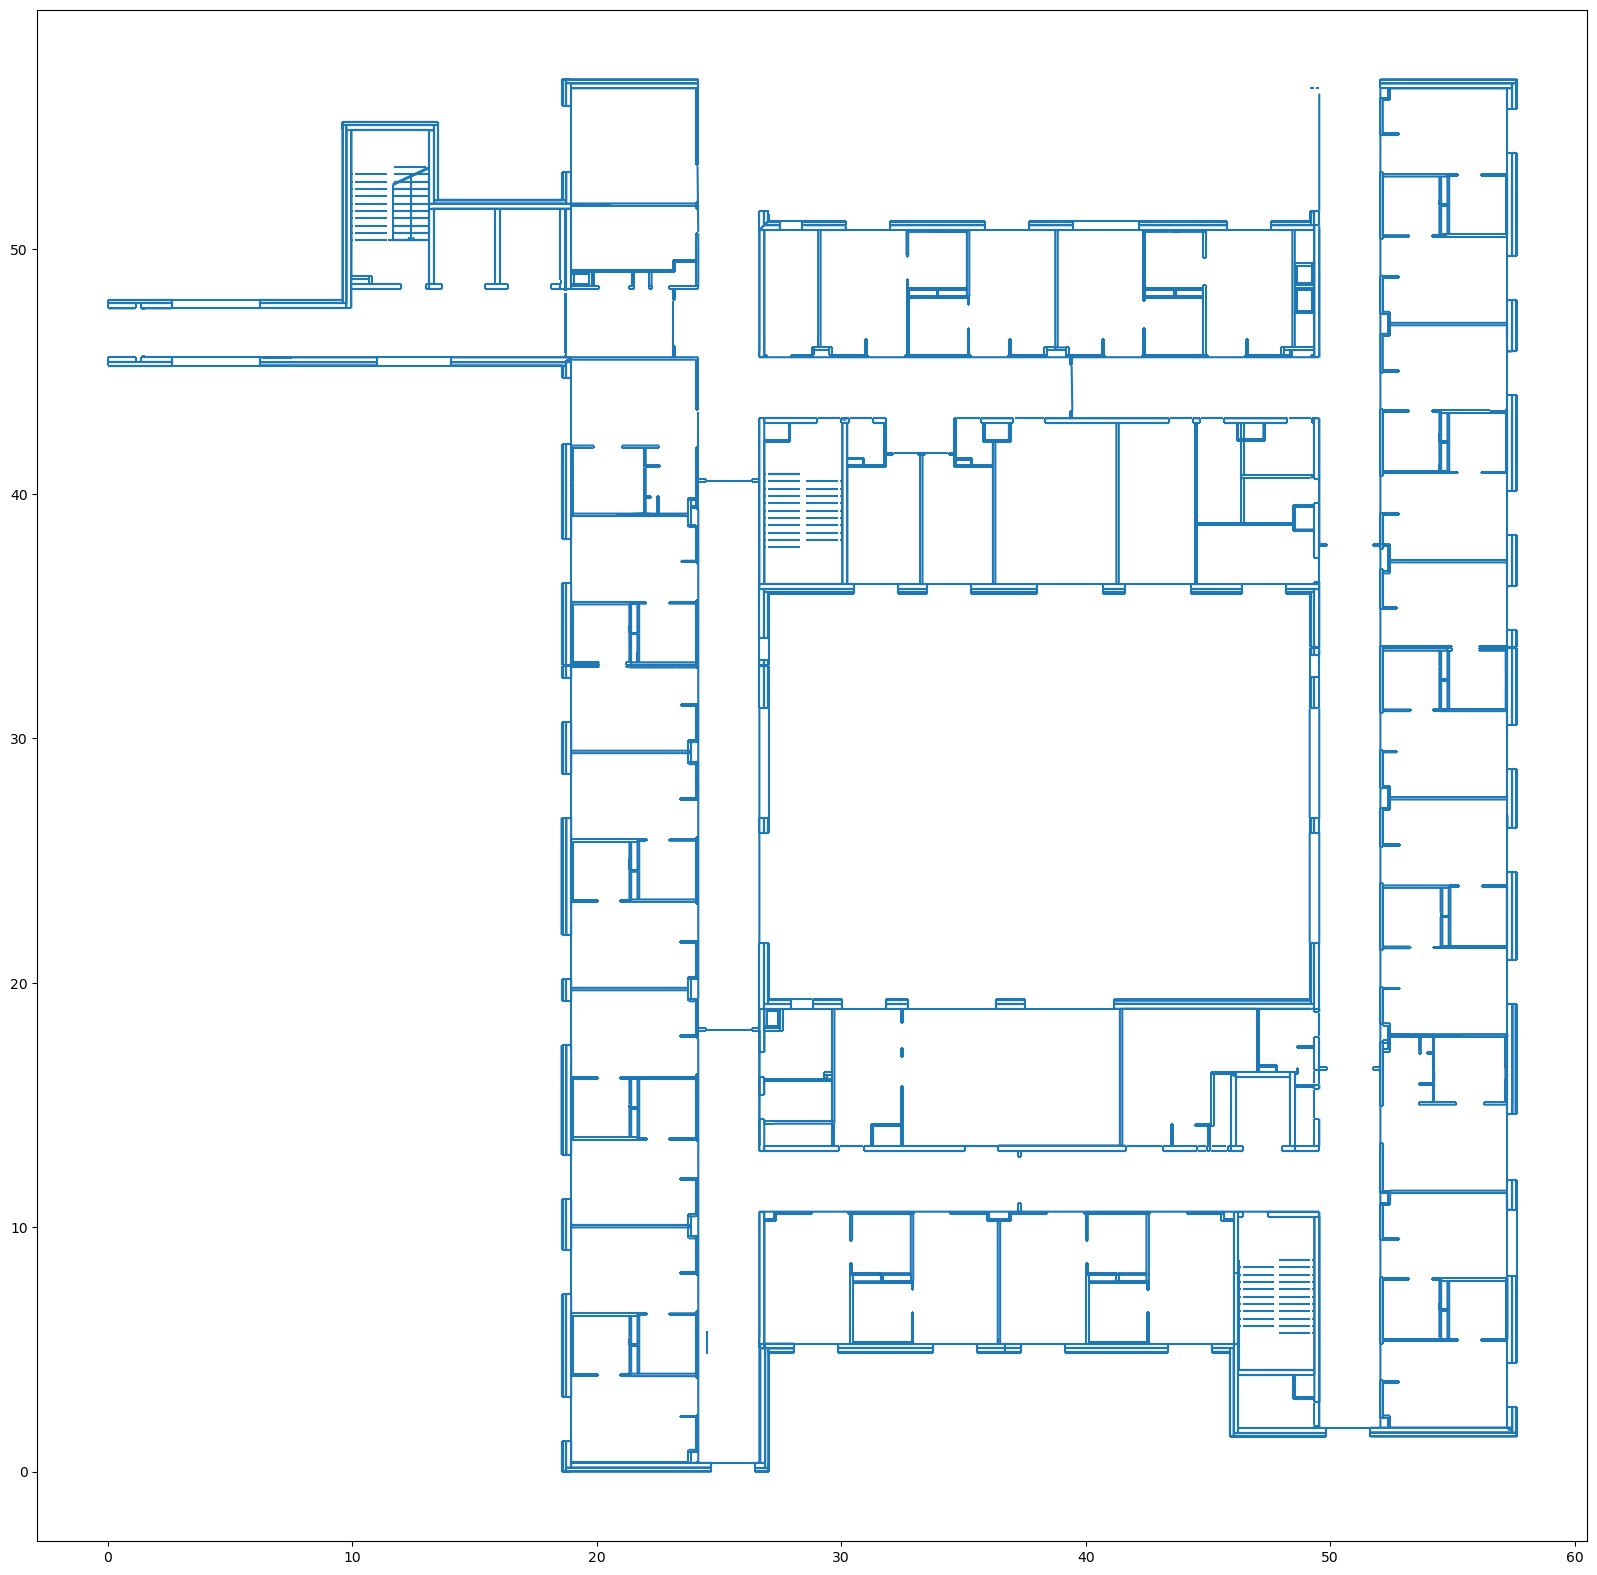

In [147]:
import geopandas as gpd

# Simplest way to plot the segments is to convert them to a GeoSeries
seg6 = gpd.GeoSeries(segments_6)
fig, ax = plt.subplots(figsize=(20, 20))
seg6.plot(ax=ax)
plt.show()


In [151]:
shapely.to_geojson(GeometryCollection(segments_6), 4)

'{\n    "type": "GeometryCollection",\n    "geometries": [\n        {\n            "type": "LineString",\n            "coordinates": [\n                [\n                    49.553484987309915,\n                    36.31100139264376\n                ],\n                [\n                    49.55344634750139,\n                    36.37899942191373\n                ]\n            ]\n        },\n        {\n            "type": "LineString",\n            "coordinates": [\n                [\n                    24.14947730956327,\n                    56.797062276159274\n                ],\n                [\n                    24.149477176902,\n                    56.93706227615921\n                ]\n            ]\n        },\n        {\n            "type": "LineString",\n            "coordinates": [\n                [\n                    57.450519873599504,\n                    11.925093831252962\n                ],\n                [\n                    57.25052037397977,\n         

## Saving as geojson

In [165]:
# Save as geojson
reload(parse_geojson)
out_dir = Path("data", "clean")
parse_geojson.save_as_geojson(
    GeometryCollection(segments_6), out_dir / "segments_6.geojson"
)

In [156]:
%load_ext autoreload

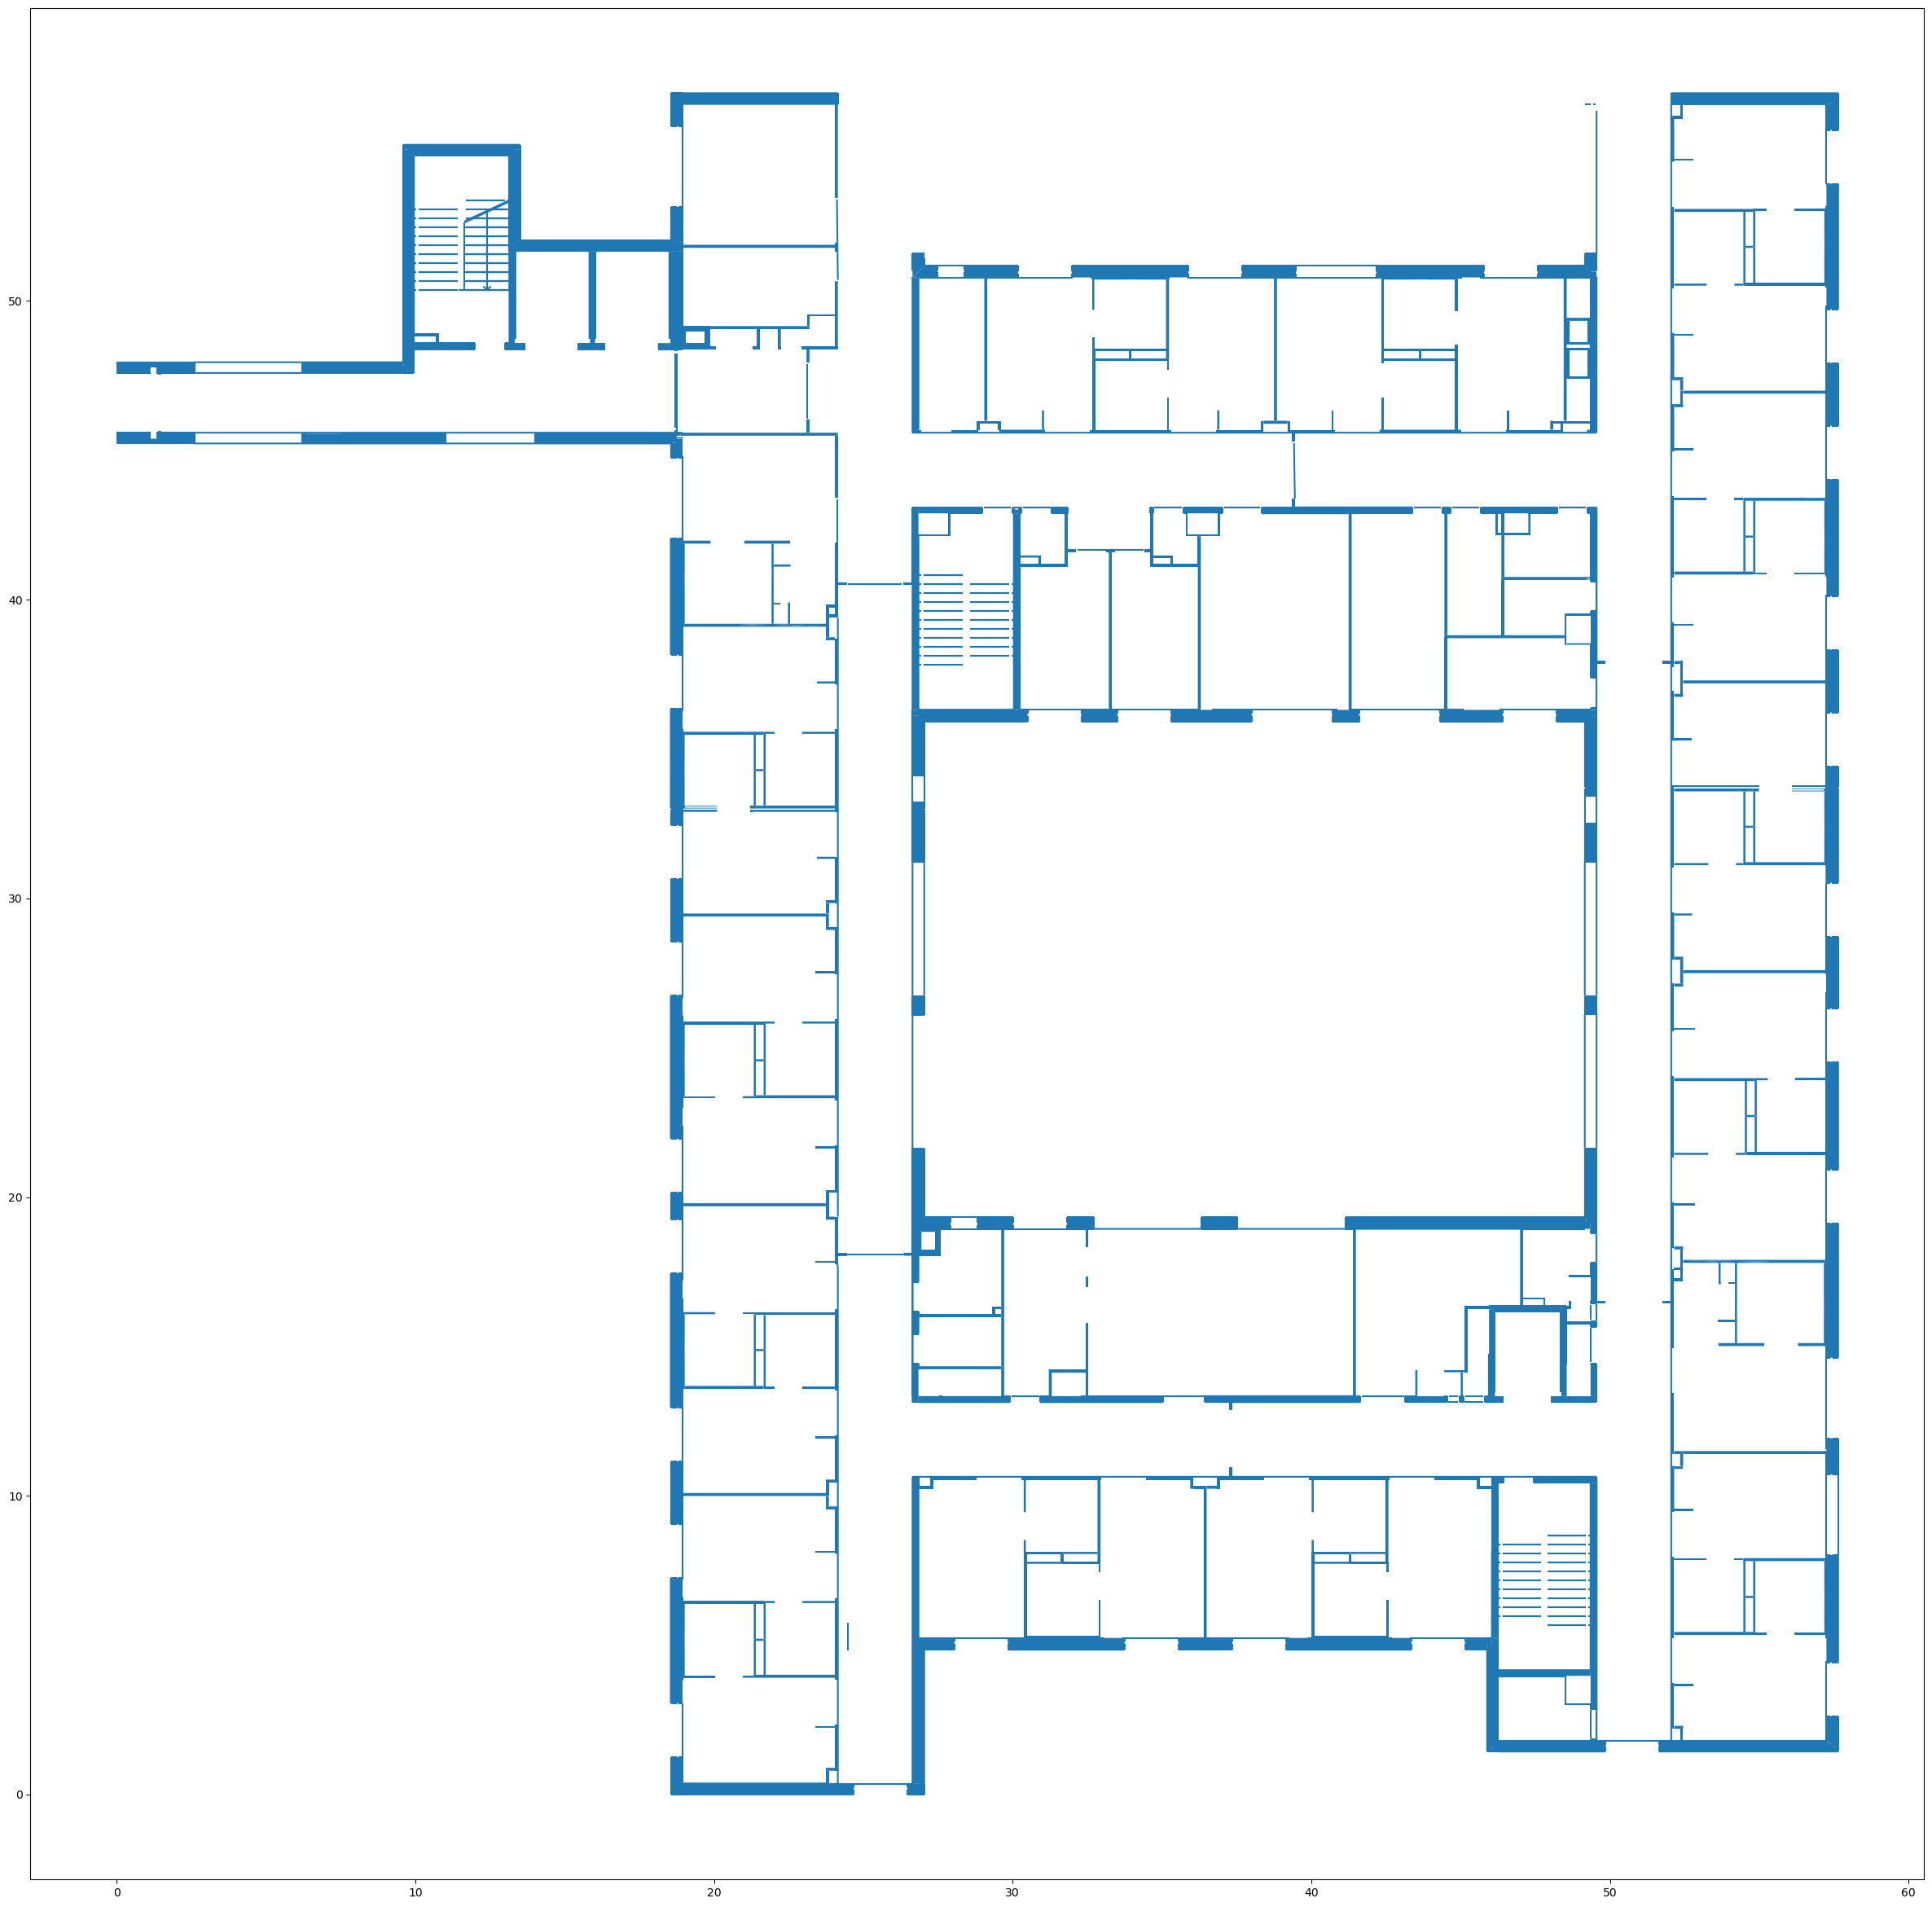

In [160]:
reload(parse_geojson)
parse_geojson.plot_GeometryCollection(geom_red)

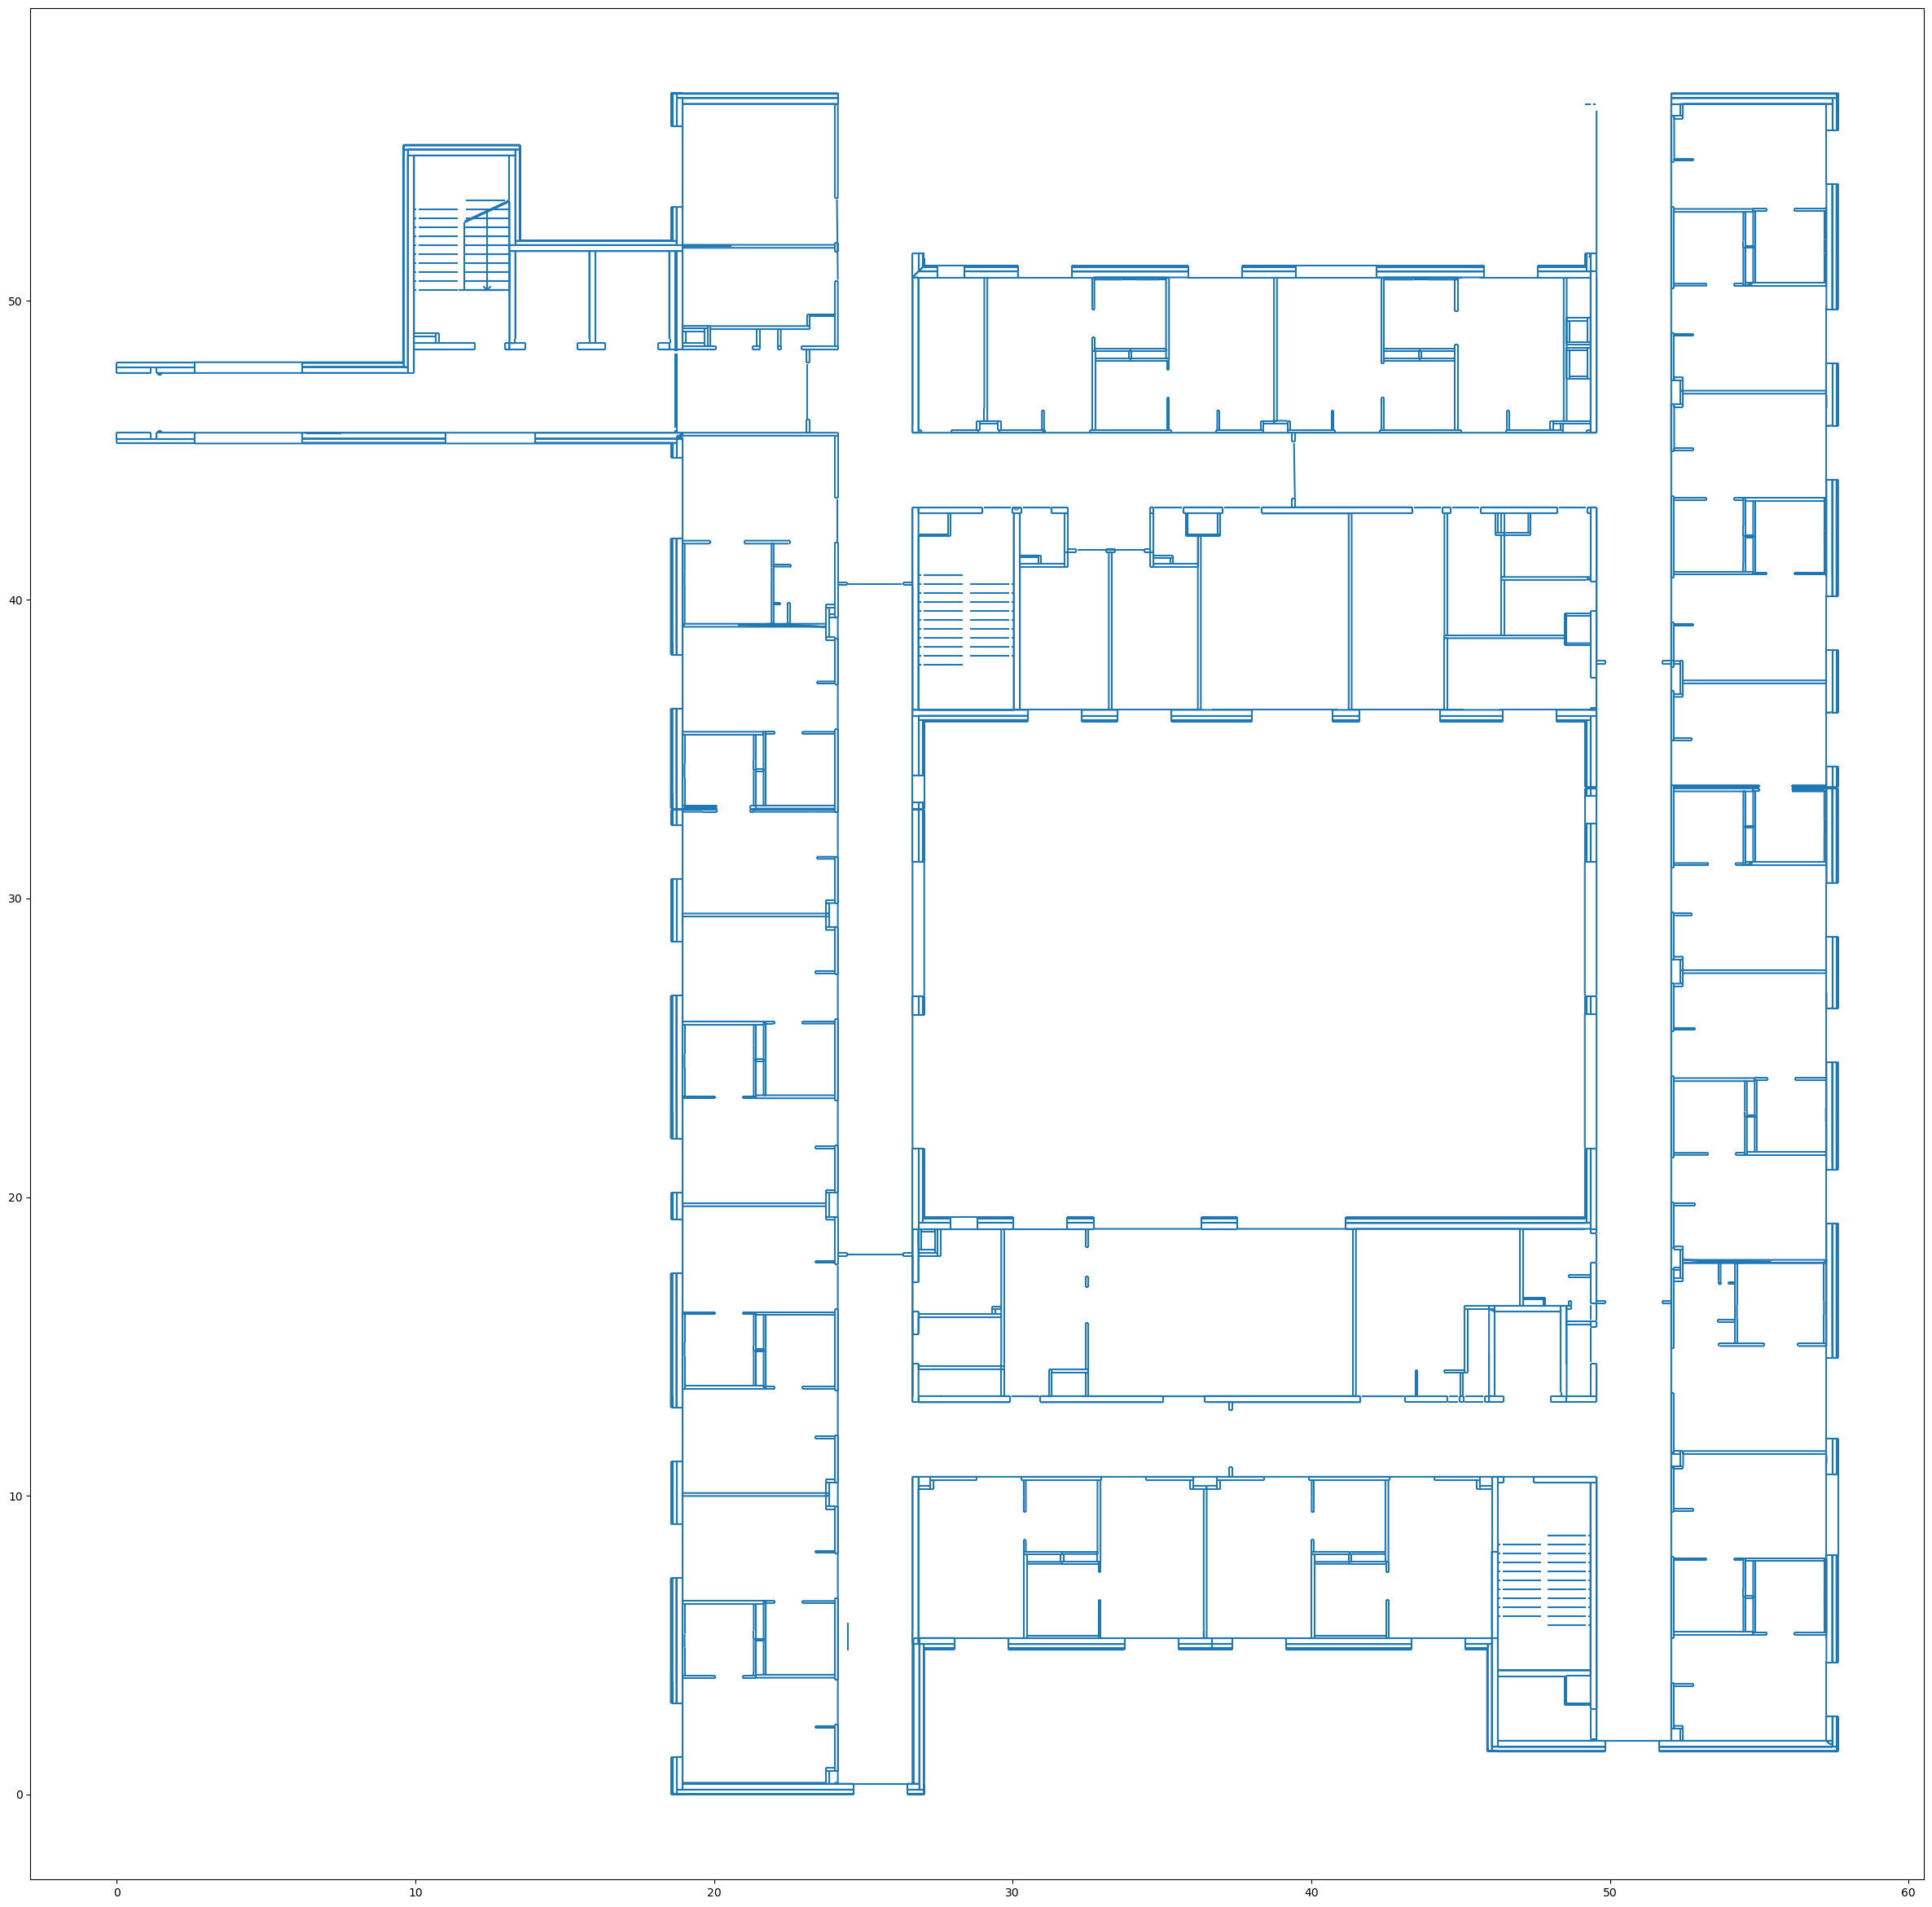

In [161]:
parse_geojson.plot_GeometryCollection(GeometryCollection(segments_6))

# Clean all output files:


In [177]:
reload(parse_geojson)
data_dir = Path("data", "geojson")
output_dir = Path("data", "clean")
for filepath in data_dir.iterdir():
    out_file = output_dir / f"{filepath.stem}_clean.geojson"
    parse_geojson.clean_geojson_to_segments_and_save(filepath, out_file)

Cleaning data/geojson/Output3.geojson to data/clean/Output3_clean.geojson
	536 segments extracted
	520 unique segments
Cleaning data/geojson/Output2.geojson to data/clean/Output2_clean.geojson
	22425 segments extracted
	22425 unique segments
Cleaning data/geojson/Output0.geojson to data/clean/Output0_clean.geojson
	5828 segments extracted
	5681 unique segments
Cleaning data/geojson/Output1.geojson to data/clean/Output1_clean.geojson
	2705 segments extracted
	1952 unique segments
Cleaning data/geojson/Output8.geojson to data/clean/Output8_clean.geojson
	50978 segments extracted
	50874 unique segments
Cleaning data/geojson/Output4.geojson to data/clean/Output4_clean.geojson
	998 segments extracted
	964 unique segments
Cleaning data/geojson/Output5.geojson to data/clean/Output5_clean.geojson
	505 segments extracted
	505 unique segments
Cleaning data/geojson/Output7.geojson to data/clean/Output7_clean.geojson
	6240 segments extracted
	6013 unique segments
Cleaning data/geojson/Output6.geoj

In [170]:
# What is the name of the file, without the extension ?
filepath = Path("data", "geojson", "Output0.geojson")
filename = filepath.stem

PosixPath('data/geojson')